<a href="https://colab.research.google.com/github/keith-leung/Celia/blob/master/ANNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as tr
import itertools as it
import matplotlib.pyplot as pt
import numpy as np

In [ ]:
# make all possible 0|1 input patterns
inputs = tr.tensor(list(it.product([0, 1], repeat=2))).float()
print(inputs)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])


In [ ]:
# make target labels
f = tr.all # logical and
# f = tr.any # logical or

targets = f(inputs, dim=1).float()
print(targets)

tensor([0., 0., 0., 1.])


In [ ]:
# initialize network parameters
w = tr.randn(2, requires_grad=True)
b = tr.randn(1, requires_grad=True)
print(w)
print(b)

tensor([-1.7957, -1.5212], requires_grad=True)
tensor([1.1489], requires_grad=True)


In [ ]:
# define NN forward pass and loss function

# differentiable approximation of heaviside function
def sigmoid(a):
  return (tr.exp(-a) + 1)**(-1)

def net(x):
  return sigmoid((w*x).sum() + b)

def loss(x, target):
  y = net(x)
  return tr.sum((y - target)**2)

print(loss(inputs[0], targets[0]))

tensor(5.8500e-07, grad_fn=<SumBackward0>)


In [ ]:
# gradient descent loop

η = 0.1 # learning rate eta

# Repeatedly take steps in the gradient direction
for step in range(1000):

  # Accumulate loss and its gradient over all examples
  batch_loss = 0
  for n in range(len(inputs)):
    example_loss = loss(inputs[n], targets[n])
    batch_loss += example_loss
    example_loss.backward()
    
  # Take gradient descent step
  w.data -= η * w.grad
  b.data -= η * b.grad

  # zero out gradients for torch before next step
  w.grad *= 0
  b.grad *= 0

  # print progress updates
  if step % 100 == 0:
    print("%d: %f" % (step, batch_loss))
    print(example_loss)

0: 0.021364
tensor(0.0089, grad_fn=<SumBackward0>)
100: 0.020500
tensor(0.0085, grad_fn=<SumBackward0>)
200: 0.019701
tensor(0.0082, grad_fn=<SumBackward0>)
300: 0.018958
tensor(0.0079, grad_fn=<SumBackward0>)
400: 0.018268
tensor(0.0076, grad_fn=<SumBackward0>)
500: 0.017624
tensor(0.0073, grad_fn=<SumBackward0>)
600: 0.017022
tensor(0.0071, grad_fn=<SumBackward0>)
700: 0.016459
tensor(0.0068, grad_fn=<SumBackward0>)
800: 0.015930
tensor(0.0066, grad_fn=<SumBackward0>)
900: 0.015433
tensor(0.0064, grad_fn=<SumBackward0>)


In [ ]:
# check that the output looks good
print("input, output, target:")
for n in range(len(inputs)):
  y = net(inputs[n])
  print(inputs[n], y, targets[n])

input, output, target:
tensor([0., 0.]) tensor([0.0004], grad_fn=<PowBackward0>) tensor(0.)
tensor([0., 1.]) tensor([0.0661], grad_fn=<PowBackward0>) tensor(0.)
tensor([1., 0.]) tensor([0.0661], grad_fn=<PowBackward0>) tensor(0.)
tensor([1., 1.]) tensor([0.9212], grad_fn=<PowBackward0>) tensor(1.)


In [ ]:
# check if the weights/bias make sense
print("w:")
print(w)
print("b:")
print(b)

w:
tensor([5.1058, 5.1058], requires_grad=True)
b:
tensor([-7.7533], requires_grad=True)


In [ ]:
# Define a class to represent a linear layer with weights and bias
# This is just to illustrate the idea, in practice you want to use tr.nn.Linear
class Linear:
  def __init__(self, in_features, out_features):
    self.weight = tr.randn(in_features, out_features, requires_grad=True)
    self.bias = tr.randn(1, out_features, requires_grad=True)
  def parameters(self):
    return [self.weight, self.bias]
  def __call__(self, x):
    return tr.mm(x, self.weight) + self.bias

# Modules can be treated like an object with attributes
lin = Linear(2, 1)
print(lin.parameters())

# Or like a function that can be called on inputs
y = lin(inputs)
print(y)

[tensor([[ 0.1667],
        [-0.9059]], requires_grad=True), tensor([[-0.8351]], requires_grad=True)]
tensor([[-0.8351],
        [-1.7410],
        [-0.6684],
        [-1.5743]], grad_fn=<AddBackward0>)


In [ ]:
# The tr.nn.Module superclass uses __call__ to wrap a 'forward' function
# Also works better for composing with other layers, e.g. with Sequential below
class Linear(tr.nn.Module):
  def __init__(self, in_features, out_features):
    super(Linear, self).__init__()
    self.weight = tr.randn(in_features, out_features, requires_grad=True)
    self.bias = tr.randn(1, out_features, requires_grad=True)
  def parameters(self):
    return [self.weight, self.bias]
  def forward(self, x):
    return tr.mm(x, self.weight) + self.bias

# Modules can be treated like an object with attributes
lin = Linear(2, 1)
print(lin.parameters())

# Or like a function that can be called on inputs
y = lin(inputs)
print(y)

[tensor([[-0.6745],
        [-0.1922]], requires_grad=True), tensor([[1.5134]], requires_grad=True)]
tensor([[1.5134],
        [1.3212],
        [0.8389],
        [0.6467]], grad_fn=<AddBackward0>)


In [ ]:
# TODO: different combos of lin/sgd lines

# Define the network
#lin = Linear(in_features=2, out_features=1)
lin = tr.nn.Linear(in_features=2, out_features=1, bias=True)
sig = tr.nn.Sigmoid()
net = tr.nn.Sequential(lin, sig)

# MSE loss (sum instead of defaulting to mean)
loss = tr.nn.MSELoss(reduction='sum')

# Stochastic gradient descent optimizer
#sgd = tr.optim.SGD(lin.parameters(), lr=η)
sgd = tr.optim.SGD(net.parameters(), lr=η)

# Track the change in loss during training
learning_curve = []

# Repeatedly take steps in the gradient direction
for step in range(1000):

  # Accumulate loss and its gradient over all examples
  outputs = net(inputs)
  batch_loss = loss(outputs, targets.reshape(4,1))
  batch_loss.backward()

  # Save loss history
  learning_curve.append(batch_loss.item())

  # Take gradient descent step
  sgd.step()

  # zero out gradients for torch before next step
  sgd.zero_grad()

  # print progress updates
  if step % 100 == 0: print("%d: %f" % (step, batch_loss))

0: 1.017249
100: 0.471813
200: 0.297672
300: 0.215502
400: 0.166668
500: 0.134455
600: 0.111818
700: 0.095174
800: 0.082503
900: 0.072585


weights, bias:
Parameter containing:
tensor([[3.4646, 3.4646]], requires_grad=True)
Parameter containing:
tensor([-5.3062], requires_grad=True)


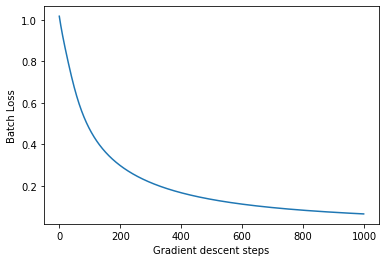

In [ ]:
# print the learned weights and bias
print("weights, bias:")
print(lin.weight)
print(lin.bias)

# visualize learning curve
pt.plot(learning_curve)
pt.xlabel("Gradient descent steps")
pt.ylabel("Batch Loss")
pt.show()

In [ ]:
# Project-related example:
# Predicting the player's win probability with a given hand of cards

# One possible way to represent the game state as a tensor:
# state[suit,number-1] = 1 if the card is in the player's hand else 0

HEARTS, CLUBS, SPADES, DIAMONDS = 0, 1, 2, 3

def state_tensor(cards):
  # cards == [..., (suit, number), ...]
  state = tr.zeros((4, 52))
  for (suit, number) in cards:
    state[suit, number-1] = 1.
  state = state.reshape(4*52) # unwrap into a long vector
  return state

print(state_tensor([(HEARTS, 1), (HEARTS, 2), (CLUBS, 1)]))

tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
# Dataset collected from multiple game-plays with tree-based AI
# data = [... (hand, final score), ...]
data = [
  ([(HEARTS, 10), (CLUBS, 10)], 0.),
  ([(HEARTS, 10), (CLUBS, 5)], 1.),
  ([(HEARTS, 10), (CLUBS, 8)], 1.),
]

inputs = tr.stack([state_tensor(hand) for (hand,_) in data])
targets = tr.tensor([score for (_, score) in data]).reshape(-1, 1)

print(inputs.shape)
print(targets.shape)

torch.Size([3, 208])
torch.Size([3, 1])


In [ ]:
# TODO: tweak for more reliable convergence?

# two-layer network configuration
cardnet = tr.nn.Sequential(
    tr.nn.Linear(208, 3),
    tr.nn.Sigmoid(),
    tr.nn.Linear(3, 1)
)

# Stochastic gradient descent optimizer
sgd = tr.optim.SGD(cardnet.parameters(), lr=η)

# Track the change in loss during training
learning_curve = []

# Repeatedly take steps in the gradient direction
for step in range(1000):

  # Accumulate loss and its gradient over all examples
  outputs = cardnet(inputs)
  batch_loss = loss(outputs, targets)

  if batch_loss < 0.0001: break

  batch_loss.backward()

  # Save loss history
  learning_curve.append(batch_loss.item())

  # Take gradient descent step
  sgd.step()

  # zero out gradients for torch before next step
  sgd.zero_grad()

  # print progress updates
  if step % 100 == 0: print("%d: %f" % (step, batch_loss))


0: 3.673153
100: 0.000432


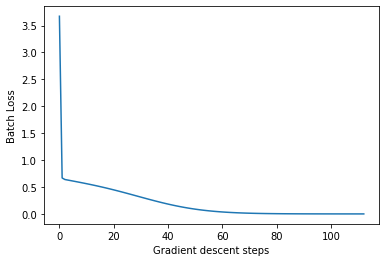

In [ ]:
# visualize learning curve
pt.plot((learning_curve))
pt.xlabel("Gradient descent steps")
pt.ylabel("Batch Loss")
pt.show()